In [1]:
import ambulance_game as abg
import numpy as np
import math
import matplotlib.pyplot as plt


# <ins> Waiting time from state probabilities </ins>


## Theoretical waiting times (M/M/c/$\infty$)


In [2]:
def probability_no_people_in_the_system(traffic_intensity, num_of_servers):
    denominator = 0
    for i in range(num_of_servers):
        denominator += ((num_of_servers * traffic_intensity) ** i) / math.factorial(i)
    denominator += ((num_of_servers * traffic_intensity) ** num_of_servers) / (
        math.factorial(num_of_servers) * (1 - traffic_intensity)
    )
    return 1 / denominator


def get_theoretical_waiting_time(Lambda, mu, num_of_servers):
    traffic_intensity = Lambda / (num_of_servers * mu)
    prob_0 = probability_no_people_in_the_system(traffic_intensity, num_of_servers)

    wait = ((num_of_servers * traffic_intensity) ** num_of_servers) / (
        math.factorial(num_of_servers)
        * mu
        * num_of_servers
        * (1 - traffic_intensity) ** 2
    )
    wait *= prob_0

    return wait


## Waiting times from state probabiliteis


**Waiting States (for ambulance and other patients):**

$$ S_w^A = \{ (u,v) \in S \; | \; u=0 \;, \; C \leq v \leq T \} $$

$$ S_w^o = \{ (u,v) \in S \; | \; v \geq C \} $$

In [43]:
def is_waiting_state(state, patient_type, num_of_servers, threshold):
    if patient_type == "ambulance":
        condition = state[0] == 0 and num_of_servers <= state[1] <= threshold
    if patient_type == "other":
        condition = state[1] >= num_of_servers
    return condition


**Accepting States (for ambulance and other patients):**

$$ S_A^A = \{ (u,v) \in S \; | \; u < N \} $$

$$ S_A^o = \{ (u,v) \in S \; | \; v < M \} $$

In [5]:
def is_accepting_state(state, patient_type, system_capacity, parking_capacity):
    if patient_type == "ambulance":
        condition = state[0] < parking_capacity
    if patient_type == "other":
        condition = state[1] < system_capacity
    return condition


**Expected waiting time in a state (when ignoring arrivals):**

$$ c(u,v) = \frac{1}{min(v,C) \mu} $$

In [6]:
def expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu):
    return 1 / (min(state[1], num_of_servers) * mu)


**Probability of a transition at state (u,v) being a service:**

$$ P_s(u,v) = 1 $$

<!-- $$ P_s(u,v) = \frac{\text{min}(v,C)\mu}{\text{min}(1, N - v)\lambda^o + \text{ min}(1, M - u)\lambda_A + \text{ min}(v,C)\mu} $$ -->

In [7]:
def probability_of_service(
    state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity
):

    return 1


#     ambulance_rate = min(1, parking_capacity - state[0]) * lambda_a
#     others_rate = min(1, system_capacity - state[1]) * lambda_o
#     service_rate = min(state[1], num_of_servers) * mu
#     total_rate = ambulance_rate + others_rate + service_rate

#     return service_rate / total_rate


**Waiting time of an individual when arriving at state (u,v):**

$$ 
w(u,v) = 
\begin{cases} 
    0, \hspace{4.85cm} \textbf{if } v < C \\
    c(u,v) + P_s w(u-1, v), \hspace{1cm} \textbf{if } u \geq 1 \textbf{ and } v = t \\
    c(u,v) + P_s w(u, v-1), \hspace{1cm} \textbf{otherwise} \\
\end{cases}
$$

In [27]:
def get_recursive_waiting_time(
    state,
    patient_type,
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
):

    if not is_waiting_state(state, patient_type, num_of_servers, threshold):
        return 0

    wait = expected_time_in_markov_state_ignoring_arrivals(state, num_of_servers, mu)
    if state[0] >= 1 and state[1] == threshold:
        wait += probability_of_service(
            state,
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            system_capacity,
            parking_capacity,
        ) * get_recursive_waiting_time(
            (state[0] - 1, state[1]),
            patient_type,
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )
        return wait

    wait += probability_of_service(
        state, lambda_a, lambda_o, mu, num_of_servers, system_capacity, parking_capacity
    ) * get_recursive_waiting_time(
        (state[0], state[1] - 1),
        patient_type,
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
    )
    return wait


**Mean Waiting Time:**

$$ W = \frac{\sum_{(u,v) \in S_A} \pi_{(u,v)} \; w(u,v)}{\sum_{(u,v) \in S_A} \pi_{(u,v)}} $$

In [47]:
def mean_waiting_time_formula(
    all_states,
    pi,
    patient_type,
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
):
    mean_waiting_time = 0
    probability_of_accepting = 0
    for u, v in all_states:
        if is_accepting_state((u, v), patient_type, system_capacity, parking_capacity):
            current_state_wait = get_recursive_waiting_time(
                (u, v),
                patient_type,
                lambda_a,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )
            mean_waiting_time += current_state_wait * pi[u, v]
            probability_of_accepting += pi[u, v]
    #             print((u,v), current_state_wait, pi[u,v])
    mean_waiting_time /= probability_of_accepting
    return mean_waiting_time


**Main functions:**

*Simuation state probabilities*

In [64]:
def get_mean_waiting_time_simulation(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    seed_num,
    num_of_trials,
    output="both",
):
    state_probabilities = abg.simulation.get_average_simulated_state_probabilities(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
        seed_num=seed_num,
        num_of_trials=num_of_trials,
    )
    all_states = [
        (u, v)
        for v in range(state_probabilities.shape[1])
        for u in range(state_probabilities.shape[0])
        if state_probabilities[u, v] > 0
    ]

    if output == "other" or output == "both":
        mean_waiting_time_other = mean_waiting_time_formula(
            all_states,
            state_probabilities,
            "other",
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )

    if output == "ambulance" or output == "both":
        mean_waiting_time_ambulance = 0
        if threshold > num_of_servers:
            mean_waiting_time_ambulance = mean_waiting_time_formula(
                all_states,
                state_probabilities,
                "ambulance",
                lambda_a,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )

    if output == "other":
        return mean_waiting_time_other
    if output == "ambulance":
        return mean_waiting_time_ambulance
    if output == "both":
        return mean_waiting_time_ambulance, mean_waiting_time_other


*Markov state probabilities*

In [66]:
def get_mean_waiting_time_markov(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    output="both",
):
    transition_matrix = abg.markov.get_transition_matrix(
        lambda_a,
        lambda_o,
        mu,
        num_of_servers,
        threshold,
        system_capacity,
        parking_capacity,
    )
    pi = abg.markov.get_steady_state_algebraically(
        transition_matrix, algebraic_function=np.linalg.solve
    )
    all_states = abg.markov.build_states(threshold, system_capacity, parking_capacity)
    state_probabilities = abg.markov.get_markov_state_probabilities(
        pi, all_states, output=np.ndarray
    )

    if output == "other" or output == "both":
        mean_waiting_time_other = mean_waiting_time_formula(
            all_states,
            state_probabilities,
            "other",
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
        )

    if output == "ambulance" or output == "both":
        mean_waiting_time_ambulance = 0
        if threshold > num_of_servers:
            mean_waiting_time_ambulance = mean_waiting_time_formula(
                all_states,
                state_probabilities,
                "ambulance",
                lambda_a,
                lambda_o,
                mu,
                num_of_servers,
                threshold,
                system_capacity,
                parking_capacity,
            )

    if output == "other":
        return mean_waiting_time_other
    if output == "ambulance":
        return mean_waiting_time_ambulance
    if output == "both":
        return mean_waiting_time_ambulance, mean_waiting_time_other


##### Plot for comparing all times


In [1]:
def get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials,
    seed_num,
    runtime,
    system_capacity,
    parking_capacity,
    plot_over,
    max_parameter_value,
    output="both",
    accuracy=None,
):
    all_times_sim = []
    all_mean_times_sim = []
    all_mean_times_markov = []

    if accuracy == None or accuracy <= 1:
        accuracy = 5

    if plot_over == "lambda_a":
        range_space = np.linspace(lambda_a, max_parameter_value, accuracy)
    elif plot_over == "lambda_o":
        range_space = np.linspace(lambda_o, max_parameter_value, accuracy)
    elif plot_over == "mu":
        range_space = np.linspace(mu, max_parameter_value, accuracy)
    elif plot_over == "num_of_servers":
        range_space = np.linspace(
            num_of_servers, max_parameter_value, max_parameter_value - num_of_servers
        )
    elif plot_over == "threshold":
        range_space = np.linspace(
            threshold, max_parameter_value, max_parameter_value - threshold
        )
    elif plot_over == "system_capacity":
        range_space = np.linspace(
            system_capacity, max_parameter_value, max_parameter_value - system_capacity
        )
    elif plot_over == "parking_capacity":
        range_space = np.linspace(
            parking_capacity,
            max_parameter_value,
            max_parameter_value - parking_capacity,
        )
    else:
        return "Arguement plot_over invalid"

    #     min_sys_cap = system_capacity
    #     max_sys_cap = min_sys_cap + 5
    #     sys_cap_space = np.linspace(min_sys_cap, max_sys_cap, max_sys_cap - min_sys_cap + 1, dtype=int)

    for parameter in range_space:
        if plot_over == "lambda_a":
            lambda_a = parameter
        elif plot_over == "lambda_o":
            lambda_a = parameter
        elif plot_over == "mu":
            mu = parameter
        elif plot_over == "num_of_servers":
            num_of_servers = int(parameter)
        elif plot_over == "threshold":
            threshold = int(parameter)
        elif plot_over == "system_capacity":
            system_capacity = int(parameter)
        elif plot_over == "parking_capacity":
            parking_capacity = int(parameter)

        times = abg.simulation.get_multiple_runs_results(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            num_of_trials=num_of_trials,
            seed_num=seed_num,
            runtime=runtime,
            system_capacity=system_capacity,
            parking_capacity=parking_capacity,
        )
        simulation_waiting_times = [np.mean(w.waiting_times) for w in times]

        mean_waiting_time_sim = get_mean_waiting_time_simulation(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            output=output,
        )
        mean_waiting_time_markov = get_mean_waiting_time_markov(
            lambda_a,
            lambda_o,
            mu,
            num_of_servers,
            threshold,
            system_capacity,
            parking_capacity,
            output=output,
        )

        all_times_sim.append(simulation_waiting_times)
        all_mean_times_sim.append(mean_waiting_time_sim)
        all_mean_times_markov.append(mean_waiting_time_markov)

    diff = (range_space[1] - range_space[0]) / 2

    plt.figure(figsize=(20, 10))
    plt.plot(range_space, all_mean_times_sim, label="Simulation State probabilities")
    plt.plot(range_space, all_mean_times_markov, label="Markov State probabilities")
    plt.violinplot(
        all_times_sim,
        positions=range_space,
        widths=diff,
        showmeans=True,
        showmedians=False,
    )
    title = (
        "Î»a="
        + str(lambda_a)
        + ", Î»o="
        + str(lambda_o)
        + ", Î¼="
        + str(mu)
        + ", C="
        + str(num_of_servers)
        + ", T="
        + str(threshold)
        + ", N="
        + str(system_capacity)
        + ", M="
        + str(parking_capacity)
    )
    plt.title(title)
    plt.xlabel(plot_over)
    plt.ylabel("Waiting time")
    plt.legend()
    plt.show()
    return range_space, all_mean_times_sim, all_mean_times_markov, all_times_sim


## Comparing Results (No ambulance arrivals)


In [70]:
lambda_a = 0.000001
lambda_o = 0.3
mu = 0.1
num_of_servers = 4
threshold = 3
system_capacity = 10
parking_capacity = 10

num_of_trials = 20
seed_num = 0
runtime = 10000


##### Compare state probabilities


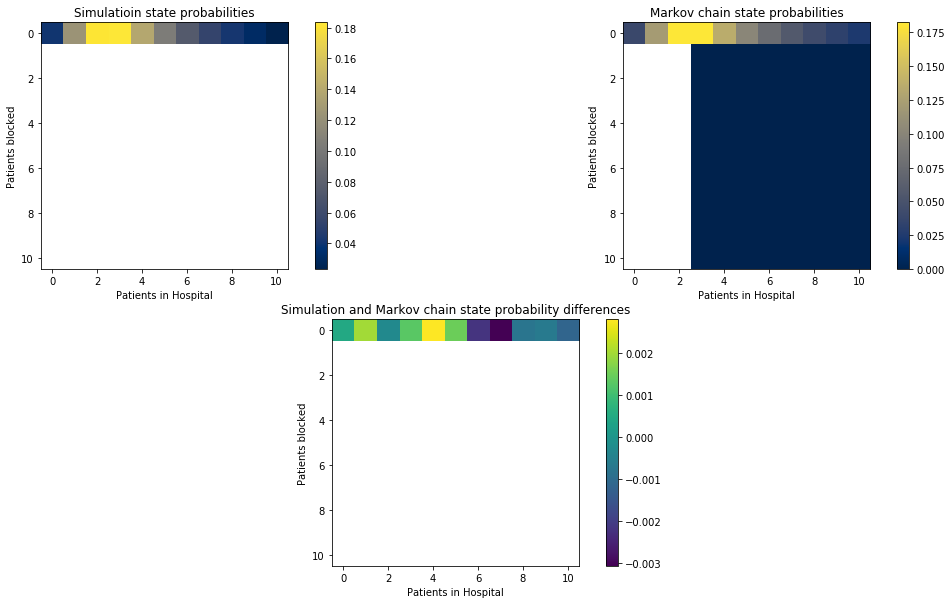

In [71]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


##### Compare Times


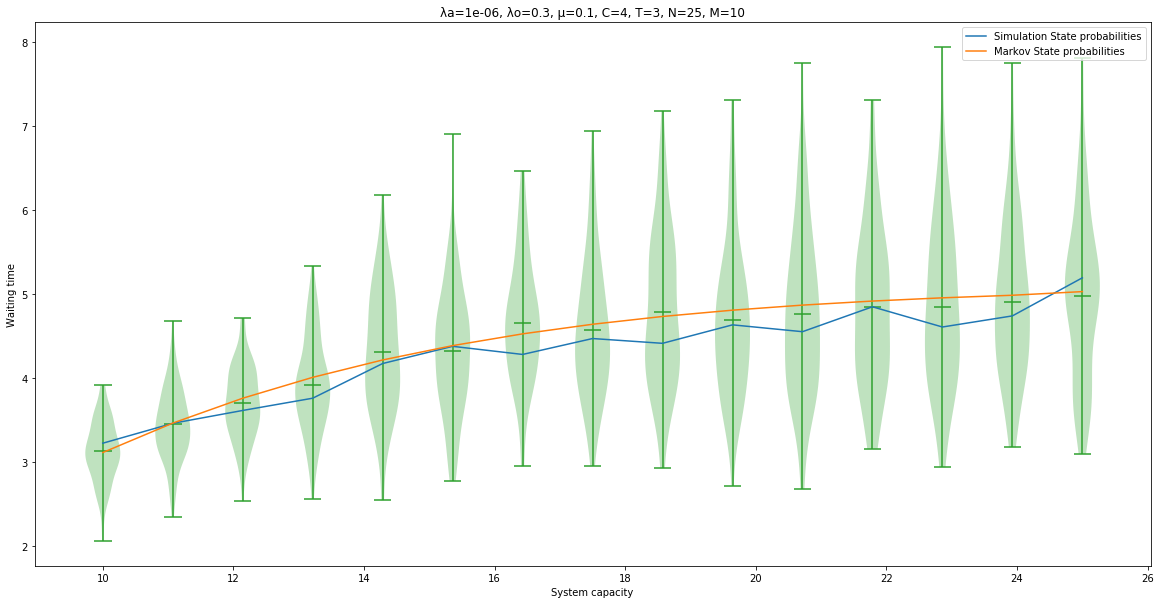

In [516]:
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    100,
    None,
    runtime,
    system_capacity,
    parking_capacity,
    "system_capacity",
    system_capacity + 15,
    output="other",
)


## Comparing results (No other arrivals)


In [87]:
lambda_a = 0.3
lambda_o = 0.0000001
mu = 0.1
num_of_servers = 5
threshold = 5
system_capacity = 20
parking_capacity = 20

num_of_trials = 5
seed_num = 0
runtime = 10000


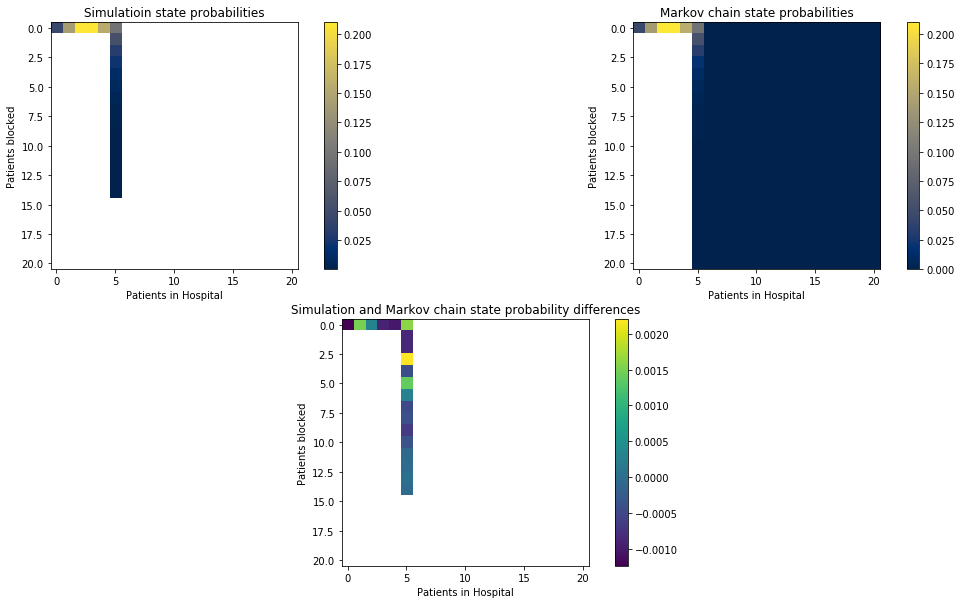

In [88]:
plt.figure(figsize=(20, 10))
abg.get_heatmaps(
    lambda_a=lambda_a,
    lambda_o=lambda_o,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
    seed_num=seed_num,
    runtime=runtime,
    num_of_trials=num_of_trials,
)


##### Simulated waiting time


In [89]:
times = abg.simulation.get_multiple_runs_results(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    num_of_trials=num_of_trials,
    seed_num=seed_num,
    runtime=runtime,
    system_capacity=system_capacity,
    parking_capacity=parking_capacity,
)
mean_waiting_time = np.mean([np.mean(w.waiting_times) for w in times])
print(mean_waiting_time)


0.0


##### Waiting time from simulated state probabilities


In [90]:
get_mean_waiting_time_simulation(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    output="ambulance",
)


0

###### Waiting time from markov state probabilities


In [91]:
get_mean_waiting_time_markov(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    parking_capacity,
    output="ambulance",
)


0

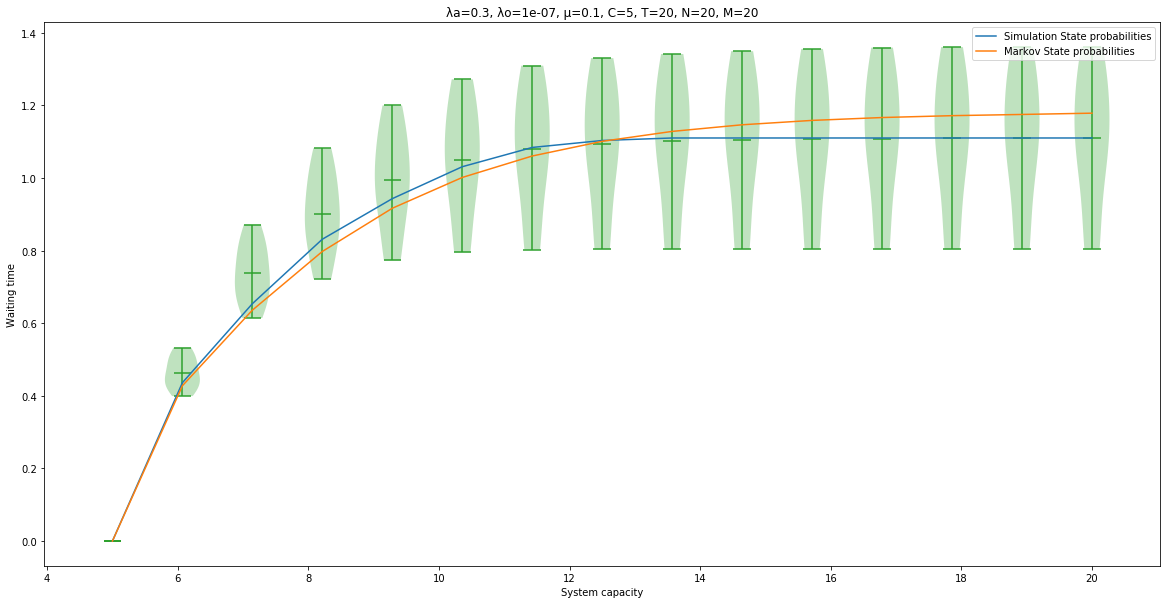

In [93]:
x_axis, mean_sim, mean_markov, all_sim = get_plot_comparing_times(
    lambda_a,
    lambda_o,
    mu,
    num_of_servers,
    threshold,
    10,
    0,
    runtime,
    system_capacity,
    parking_capacity,
    "threshold",
    threshold + 15,
    output="ambulance",
)
